In [69]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

## Data prepocessing

In [70]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

In [71]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# filter training imgs
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


## Helper Functions to display Images

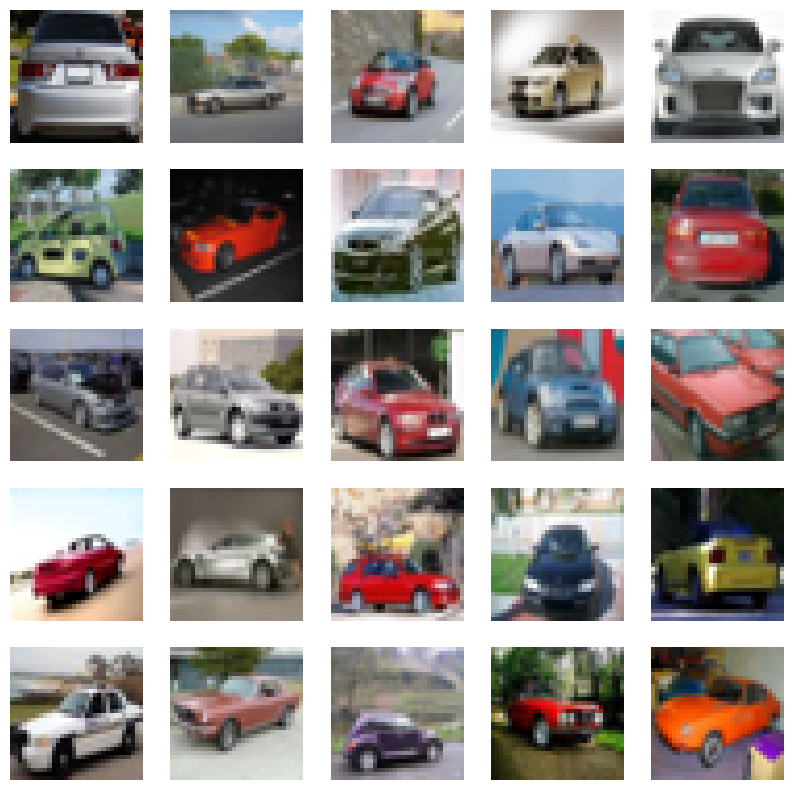

In [72]:
def cvtImg(img):
    """
    Convert and normalize images.

    Parameters:
    - img (torch.Tensor): Input image tensor.

    Returns:
    - numpy.ndarray: Converted and normalized image as a NumPy array.
    """
    # Change the order of dimensions
    img = img.permute([0, 2, 3, 1])
    
    # Normalize pixel values between 0 and 1
    img = img - img.min()
    img = img / img.max()

    # Convert the tensor to a NumPy array of type float32
    return img.numpy().astype(np.float32)

def show_examples(x):
    """
    Display a grid of image examples.

    Parameters:
    - x (torch.Tensor): Batch of input images.
    """
    plt.figure(figsize=(10, 10))

    # Convert and normalize images
    imgs = cvtImg(x)

    # Display the images in a grid
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader)) 
show_examples(x)

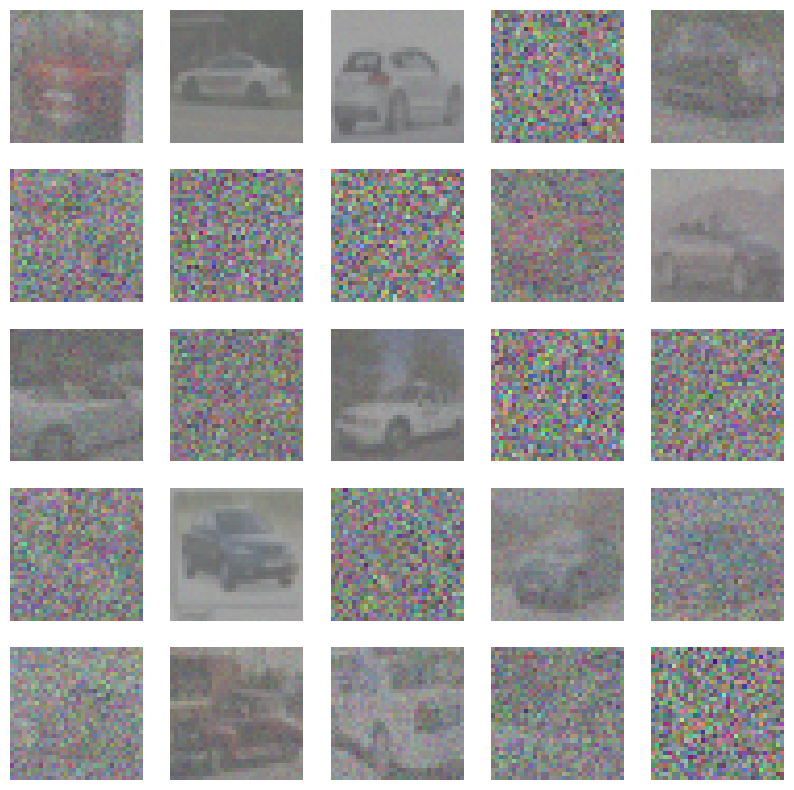

In [73]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

## Model Definition

In [74]:
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    """
    A custom neural network module representing a block.

    Args:
        in_channels (int): Number of input channels for the convolutional layers. Default is 128.
        size (int): Size of the input feature map. Default is 32.

    Attributes:
        conv_param (nn.Conv2d): Convolutional layer for processing input with parameters.
        conv_out (nn.Conv2d): Convolutional layer for generating the output.
        dense_ts (nn.Linear): Fully connected layer for processing temporal information.
        layer_norm (nn.LayerNorm): Layer normalization for normalizing the output.

    Methods:
        forward(x_img, x_ts): Forward pass of the block.

    """

    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()

        # Convolutional layer for processing input with parameters
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        # Convolutional layer for generating the output
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        # Fully connected layer for processing temporal information
        self.dense_ts = nn.Linear(192, 128)

        # Layer normalization for normalizing the output
        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        """
        Forward pass of the block.

        Args:
            x_img (torch.Tensor): Input image tensor.
            x_ts (torch.Tensor): Input temporal tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the block.

        """
        # Process input with parameters using ReLU activation
        x_parameter = F.relu(self.conv_param(x_img))

        # Process temporal information using ReLU activation and reshape
        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)

        # Element-wise multiplication of processed input and temporal information
        x_parameter = x_parameter * time_parameter

        # Generate output using convolutional layer
        x_out = self.conv_out(x_img)

        # Add the processed input and output
        x_out = x_out + x_parameter

        # Apply ReLU activation and layer normalization
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [75]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)

        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),

            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )

        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)

        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)

        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)

        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]

        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)

            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')

        # ----- output -----
        x = self.cnn_output(x)

        return x

model = Model().to(device)

## Training

In [76]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)

    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)

    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()

    return loss.item()

In [77]:
def train(R=50):
    loss_l=[]
    bar = trange(R)
    total = len(trainloader)
    for i in bar:
        loss_list=[]
        for j, (x_img, _) in enumerate(trainloader):
            loss = train_one(x_img)
            loss_list.append(loss)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')
        loss_l.append(sum(loss_list)/len(loss_list))
    return loss_l

In [78]:
loss=train(R=40)

  0%|          | 0/40 [00:00<?, ?it/s]

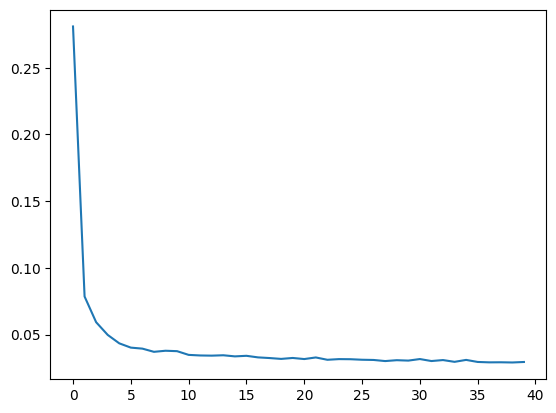

In [79]:
plt.plot(loss)
plt.show()

## Image Generation

In [80]:
import cv2
import matplotlib.pyplot as plt
from tqdm import trange

def generate_images(num_images):
    model.eval()
    xs = []
    generated_images = []

    with torch.no_grad():
        for _ in trange(num_images):
            x = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
            for i in range(timesteps):
                t = i
                x = model(x, torch.full([1, 1], t, dtype=torch.float, device=device))
            generated_images.append(x[0].cpu())

    generated_images = torch.stack(generated_images, dim=0)
    generated_images = torch.clip(generated_images, -1, 1)
    generated_images = cvtImg(generated_images)

    for i in range(num_images):
        plt.imshow(generated_images[i])
        plt.axis('off')
        xs.append(torch.tensor(generated_images[i]).unsqueeze(0).permute(0,3,2,1))
        plt.savefig(f'generated_image_{i+1}.png')
        plt.show()  # Display the image
        plt.close()

    return xs


100%|██████████| 10/10 [00:00<00:00, 18.90it/s]


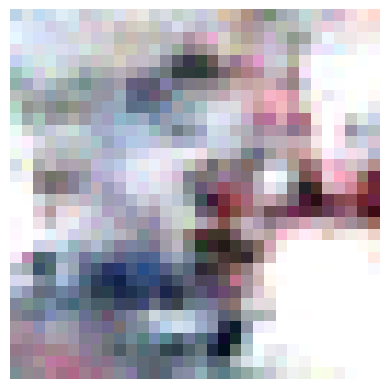

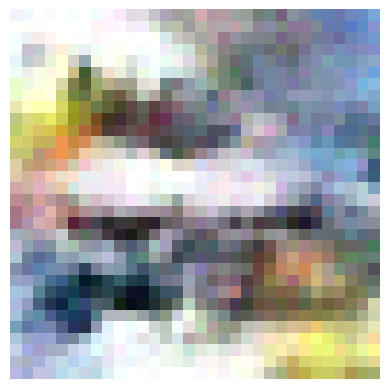

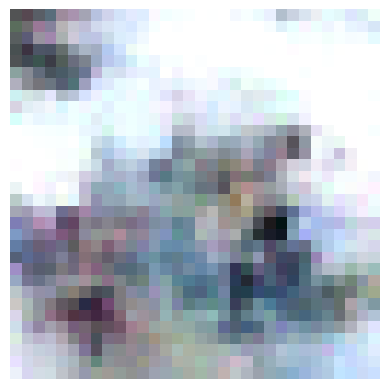

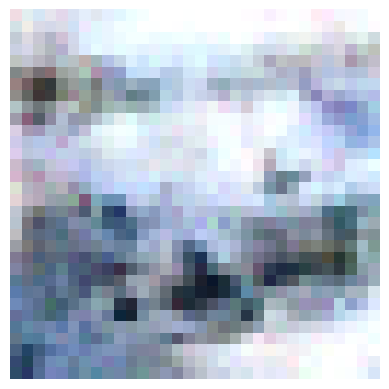

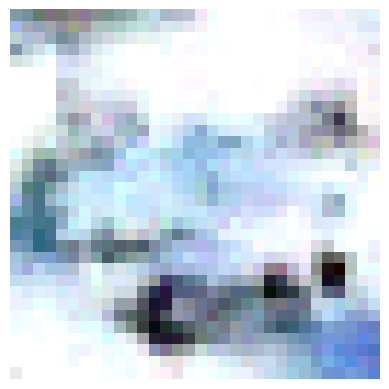

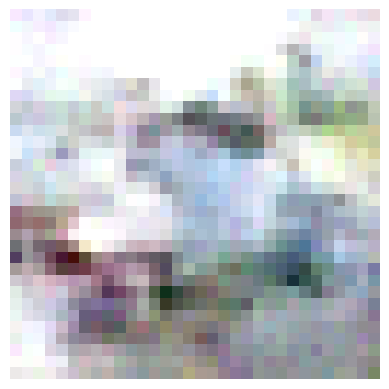

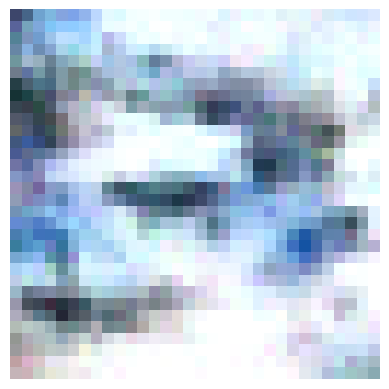

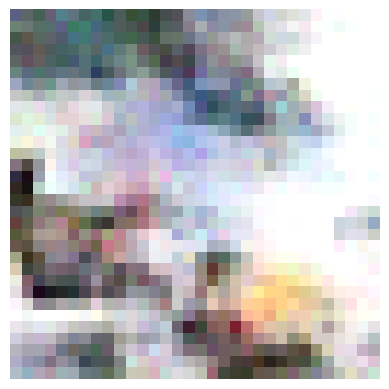

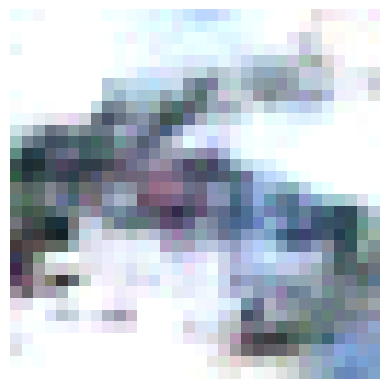

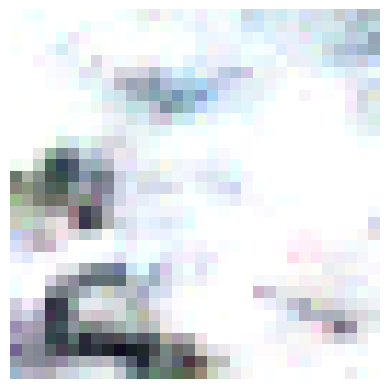

In [81]:
images=generate_images(10)

## Inception Score

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=10, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0
    assert N == batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)

    # Load Inception v3 model
    inception_model = models.inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


print("Calculating Inception Score...")
print((inception_score(images, cuda=True, batch_size=10, resize=True, splits=1)))

Calculating Inception Score...
(1.52, 0)
